## Kodlama Günü 3: Zaman Serisi


Bu notebook, üçüncü kodlama gününde uğraşacağımız zaman serisi problemine giriş için verilmiştir. Veri kümesi [Google Drive](https://drive.google.com/file/d/1fWjVFWh1VCXosAjVhLLmbnjO6CMK3Smu/view?usp=sharing)'a ve Blackboarda yüklenmiştir. Aynı zamanda kaynak [link](https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption) verilmiştir. Kaynak linkte verinin tanımı mevcuttur. 

Bu veri kümesi Aralık 2006 ile Kasım 2010 arasında (toplam 47 ay) bir eve ait elektrik tüketim rakamlarını dakika çözünürlüğünde vermektedir. Bu veri kümesi üzerinde geliştireceğiniz yapay sinir ağları (örn: GRU) tabanlı bir regresyon algoritması ile herhangi bir zamanda bu zamandan önce yapılmış ölçümlerin dilediğiniz kadarını kullanarak sonraki bir saat içerisinde gerçekleşecek tüketim miktarını (global_active_power sütunu hedef değişkeni göstermektedir) kestirmeniz istenmektedir. 

Verilen ham verideki eksikliklerin tamamlanması, eğitim-test kümelerine ayırma şekli (zaman-serileri için çapraz geçerlilik fikirlerini hatırlayın) model seçimi ve performans metriklerinin belirlenmesi vb. adımlar size bırakılmıştır. Yapay sinir ağları kullanmaktan başka bir kısıt yoktur. Gün sonunda tercihlerinizi anlatmanız beklenmektedir.

Bu notebook'ta işinizi kolaylaştırmak başlangıç kodu bulunmaktadır.

Not: Dakikalık veri yerine saatlik ortalama veri ile başlamanızı tavsiye ederiz. Aşağıda saatlik veriye kolay ulaşmak için kod mevcut.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as Layers

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


In [3]:
def setupMatplotLib():
    plt.rc('figure', figsize=(15,7))
    plt.rc('font', size=14)
setupMatplotLib()

def plot_history(histories, vertical=False, otherkey='accuracy'):
    plt.rc('figure', figsize=(14,8))
    if vertical:
        p,r = 2,1
    else:
        p,r = 1,2 
    anyPlots = False
    k=1
    for name, history in histories:
        if 'val_loss' in history.history.keys():
            anyPlots = True
            
            ax = plt.subplot(p,r,1)
            val = ax.plot(history.epoch, history.history['val_loss'],
                           '--', label=name.title()+' Val')
            ax.plot(history.epoch, history.history['loss'], color=val[0].get_color(),
                     label=name.title()+' Train')
        elif 'loss' in history.history.keys():
            anyPlots = True
            
            ax = plt.subplot(p,r,1)
            ax.plot(history.epoch, history.history['loss'], label=name.title()+' Train')
            
        if 'val_' + otherkey in history.history.keys():
            k = 2
            anyPlots = True
            
            ax = plt.subplot(p,r,2)
            val = ax.plot(history.epoch, history.history['val_' + otherkey],
                           '--', label=name.title()+' Val')
            ax.plot(history.epoch, history.history[otherkey], color=val[0].get_color(),
                     label=name.title()+' Train')
        elif otherkey in history.history.keys():
            k = 2
            anyPlots = True
            
            ax = plt.subplot(p,r,2)
            ax.plot(history.epoch, history.history[otherkey], label=name.title()+' Train')
        plt.rc('figure', figsize=(10,7))

    if anyPlots:
        for i in range(1,k+1):
            if i == 1:
                key = histories[0][1].model.loss
            else:
                key = otherkey
            ax = plt.subplot(p,r,i)
            ax.set_xlabel('Epochs')
            if type(key) == str:
                ax.set_ylabel(key.replace('_',' ').title())
            ax.legend()
        plt.tight_layout()

In [4]:
data = pd.read_csv('./data/household_power_consumption.txt', 
                   delimiter=';', 
                   parse_dates={'dt' : ['Date', 'Time']}, 
                   infer_datetime_format=True, 
                   low_memory=False, 
                   na_values=['nan','?'], 
                   index_col='dt')
data.shape

(2075259, 7)

In [5]:
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [7]:
data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [8]:
nanDF = data.isna().sum().to_frame(name='Count')
nanDF['Ratio'] =data.isna().mean()
nanDF

,Count,Ratio
Global_active_power,25979,0.012518
Global_reactive_power,25979,0.012518
Voltage,25979,0.012518
Global_intensity,25979,0.012518
Sub_metering_1,25979,0.012518
Sub_metering_2,25979,0.012518
Sub_metering_3,25979,0.012518


In [9]:
data.fillna(method='ffill',inplace=True)
data.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

<AxesSubplot:>

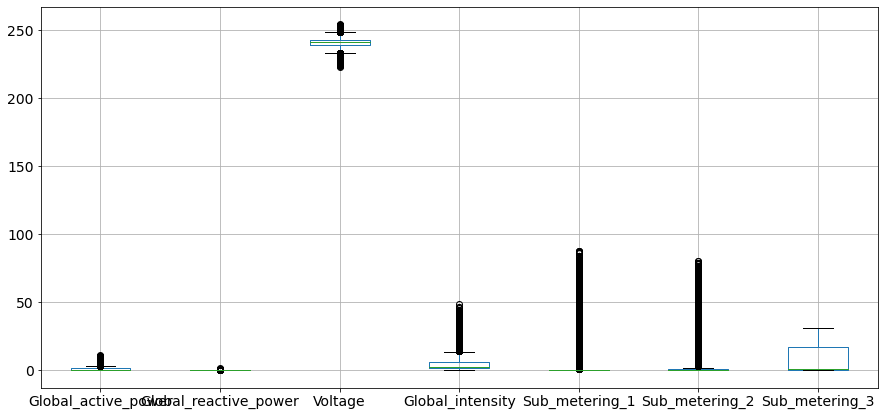

In [10]:
data.boxplot()

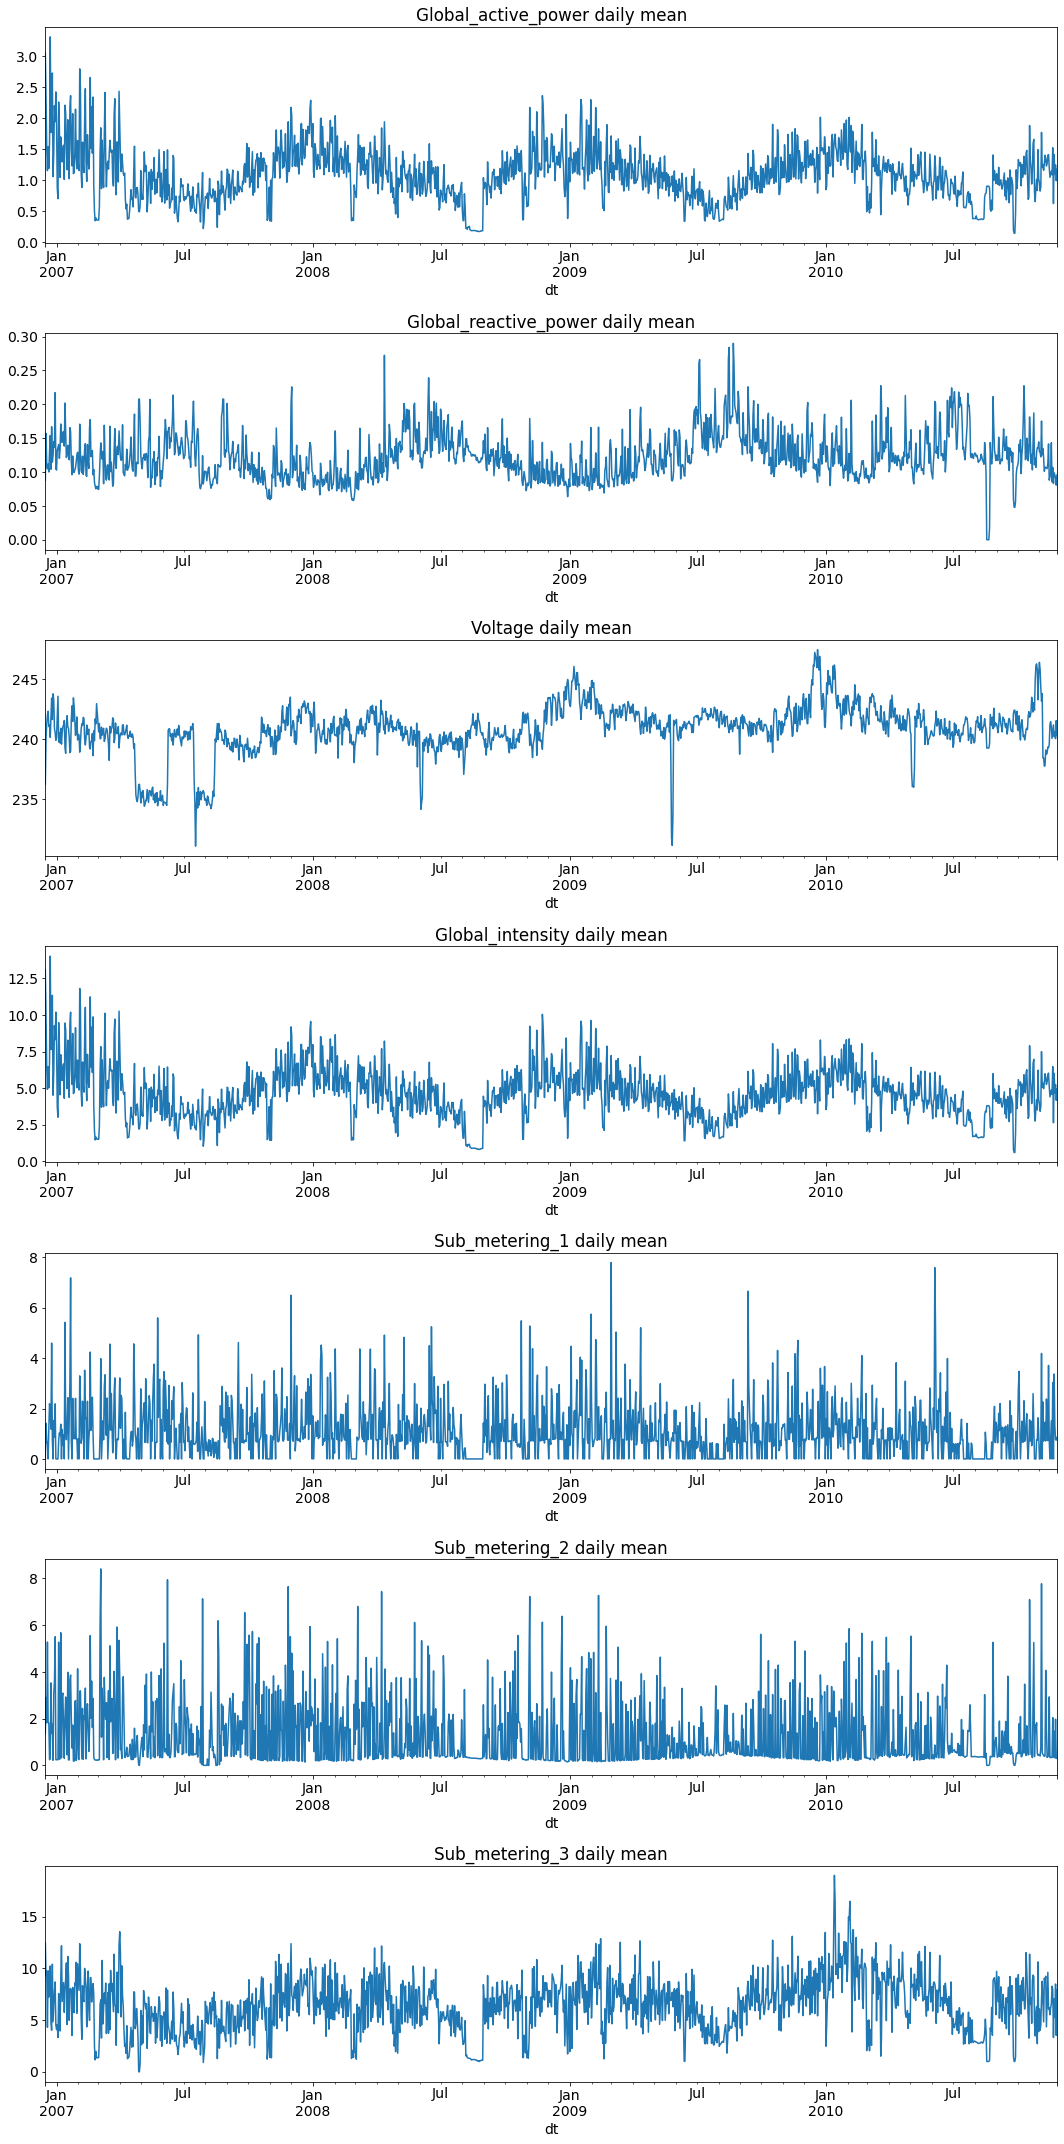

In [11]:
numC = len(data.columns)
plt.rc('figure', figsize=(15,30))
i = 1
for col in data.columns:
    ax = plt.subplot(numC,1,i)
    data.resample('D')[col].mean().plot(title=col+' daily mean')
    i += 1
plt.tight_layout()
plt.rc('figure', figsize=(15,7))

Dakikalık veri çok büyük, saatlik veriye çevirerek başlayalım

In [12]:
dataHourly = data.resample('H').mean()

<AxesSubplot:>

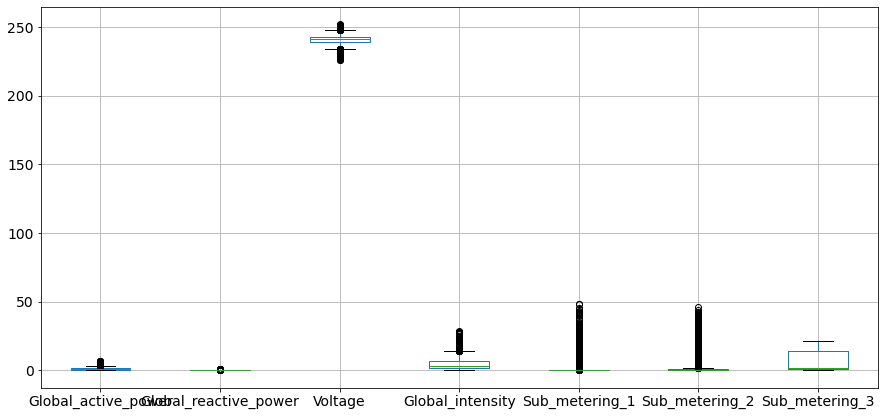

In [13]:
dataHourly.boxplot()

Burada train-test diye sabit ayırıyoruz, ancak çapraz geçerlilik yapmak isterseniz farklı olması gerek:

In [45]:
dataTrain = dataHourly[:'2008-12-31 23:59:00']
dataVal = dataHourly['2008-12-31 23:59:00':'2009-12-31 23:59:00']
dataTest = dataHourly['2009-12-31 23:59:00':]

In [46]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

sc = RobustScaler()#MinMaxScaler()#RobustScaler()#StandardScaler()

xTrain = sc.fit_transform(dataTrain)
xVal = sc.transform(dataVal)
xTest = sc.transform(dataTest)

yTrain = xTrain[:,0]
yTrain = yTrain.reshape((yTrain.shape[0],1))

yVal = xVal[:,0]
yVal = yVal.reshape((yVal.shape[0],1))

yTest = xTest[:,0]
yTest = yTest.reshape((yTest.shape[0],1))


In [47]:
windowSize = 48

generatorTrain = keras.preprocessing.sequence.TimeseriesGenerator(xTrain, yTrain, length=windowSize, batch_size=10, shuffle=True)
generatorVal = keras.preprocessing.sequence.TimeseriesGenerator(xVal, yVal, length=windowSize, batch_size=yVal.shape[0]-windowSize)
generatorTest = keras.preprocessing.sequence.TimeseriesGenerator(xTest, yTest, length=windowSize, batch_size=yTest.shape[0]-windowSize)

In [48]:
rnnSimple = Sequential([
    Layers.GRU(units=32, return_sequences=False, input_shape=(windowSize, xTrain.shape[1])),
    Layers.Dropout(0.2),
    Layers.Dense(units = 10,activation='relu'),
    Layers.Dense(units = 1)
])

rnnSimple.compile(optimizer='adam',loss='mean_squared_error', metrics=['mae'])
rnnSimple.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, 32)                3936      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                330       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 11        
Total params: 4,277
Trainable params: 4,277
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
1787/1787 [==============================] - 9s 5ms/step - loss: 0.2759 - mae: 0.3763 - val_loss: 0.1824 - val_mae: 0.3068
Epoch 2/50
1787/1787 [==============================] - 8s 5ms/step - loss: 0.2166 - mae: 0.3273 - val_loss: 0.1737 - val_mae: 0.2851
Epoch 3/50
1787/1787 [==============================] - 8s 4ms/step - loss: 0.2064 - mae: 0.3151 - val_loss: 0.1689 - val_mae: 0.2855
Epoch 4/50
1787/1787 [==============================] - 8s 4ms/step - loss: 0.1951 - mae: 0.3058 - val_loss: 0.1605 - val_mae: 0.2761
Epoch 5/50
1787/1787 [==============================] - 8s 4ms/step - loss: 0.1889 - mae: 0.2988 - val_loss: 0.1599 - val_mae: 0.2796
Epoch 6/50
1787/1787 [==============================] - 8s 4ms/step - loss: 0.1922 - mae: 0.3008 - val_loss: 0.1622 - val_mae: 0.2777
Epoch 7/50
1787/1787 [==============================] - 8s 4ms/step - loss: 0.1882 - mae: 0.2999 - val_loss: 0.1561 - val_mae: 0.2640
Epoch 8/50
1787/1787 [==============================] - 8s 4ms

f:\python\python37_64\lib\site-packages\ipykernel_launcher.py:52: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


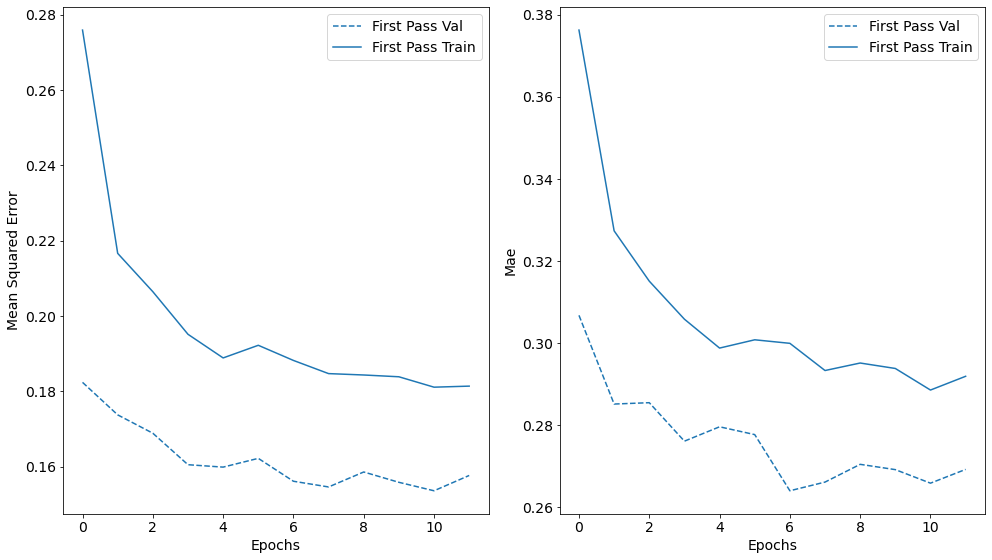

In [49]:
earlyStop = keras.callbacks.EarlyStopping(monitor='val_mae', patience=5)
modelSave = keras.callbacks.ModelCheckpoint('./checkpoint_fp',monitor='val_mae',save_best_only=True,
    save_weights_only=True, mode='min',)

history = rnnSimple.fit(generatorTrain, steps_per_epoch=len(generatorTrain), epochs=50, 
                        validation_data=generatorVal, callbacks = [earlyStop,modelSave])

plot_history([('First Pass',history)],otherkey='mae')

In [50]:
rnnSimple.load_weights('./checkpoint_fp')
rnnSimple.evaluate(generatorTest)

1/1 [==============================] - 0s 2ms/step - loss: 0.1492 - mae: 0.2631


[0.1491924673318863, 0.2630555331707001]

In [51]:
ypred = rnnSimple.predict(generatorTest)

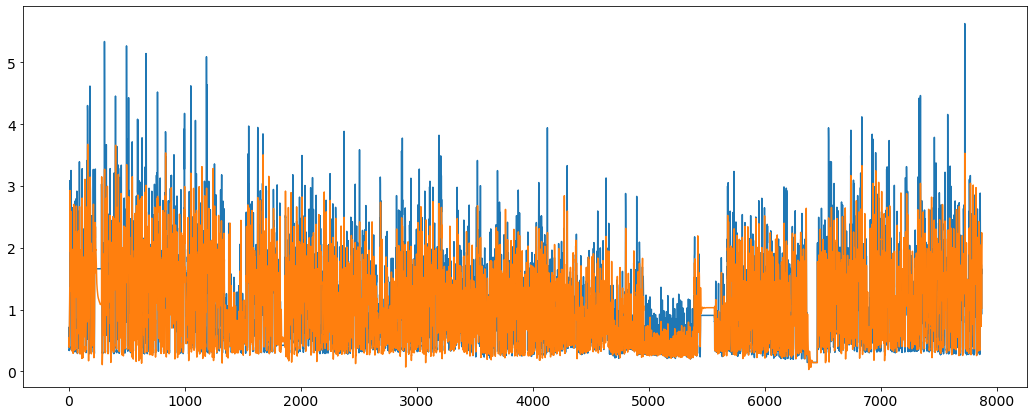

In [52]:
a=sc.scale_[0]
b=sc.center_[0]

plt.rc('figure', figsize=(18,7))
plt.plot(yTest[windowSize:]*a+b)
plt.plot(ypred*a+b)
plt.rc('figure', figsize=(15,7))


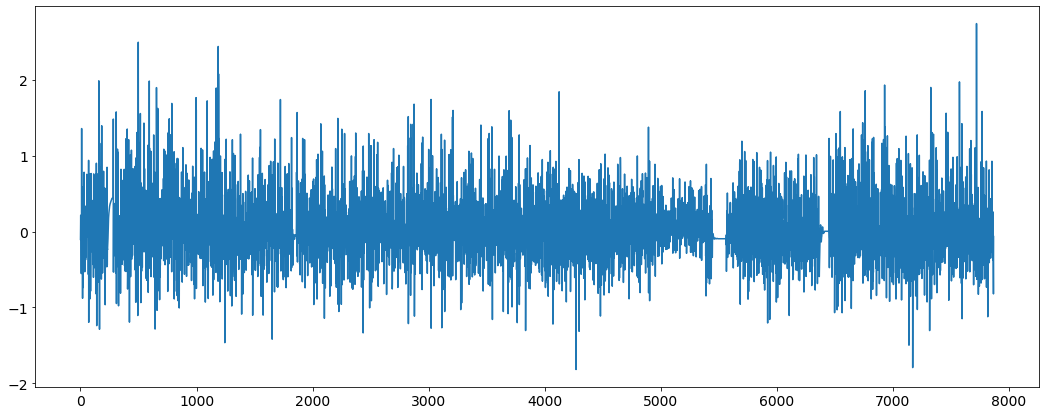

In [53]:
plt.rc('figure', figsize=(18,7))
plt.plot(yTest[windowSize:]-ypred)
plt.rc('figure', figsize=(15,7))
